## IN4640 Assignment 02 — Fitting and Alignment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import requests
from PIL import Image
import io
from sklearn.linear_model import RANSACRegressor, LinearRegression

np.random.seed(42)
plt.rcParams['figure.dpi'] = 120
print('All imports successful.')

All imports successful.


#### Q1(a)

In [2]:
#load data
D = np.genfromtxt('data/lines.csv', delimiter=',', skip_header=1)
print('Data shape:', D.shape)
print('First 5 rows:\n', D[:5])

Data shape: (100, 6)
First 5 rows:
 [[ -5.30547099  -4.06009155  -5.26129006 -12.66633342  -3.79615021
    3.69171161]
 [ -5.5403588   -5.0031803   -3.99259187 -11.00772693  -3.98562503
    4.90000402]
 [ -4.98212753  -4.58449362  -4.33122591 -11.69731474  -3.58927699
    5.04686274]
 [ -4.49570614  -5.06413838  -4.78201809 -11.97801037  -3.59707103
    4.63593624]
 [ -4.44215386  -4.41137023  -4.5675092  -12.41495176  -2.79950409
    4.73969871]]


In [3]:
def total_least_squares_line(x, y):
    
    #center the data
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    #matrix of centered points
    X = np.column_stack([x - x_mean, y - y_mean])
    
    #SVD to find normal vector
    _, _, Vt = np.linalg.svd(X)
    normal = Vt[-1]
    a, b = normal
    
    #cacl c using mean points
    c = -(a * x_mean + b * y_mean)
    
    print(f'  a = {a:.6f}')
    print(f'  b = {b:.6f}')
    print(f'  c = {c:.6f}')
    
    if abs(b) > 1e-10:
        slope = -a / b
        intercept = -c / b
        print(f'Equivalent: y = {slope:.4f}x + {intercept:.4f}')
    
    return a, b, c

x1 = D[:, 0]
y1 = D[:, 3]

print('Line 1 parameters:')
a1, b1, c1 = total_least_squares_line(x1, y1)

Line 1 parameters:
  a = 0.773562
  b = -0.633721
  c = -3.794192
Equivalent: y = 1.2207x + -5.9872


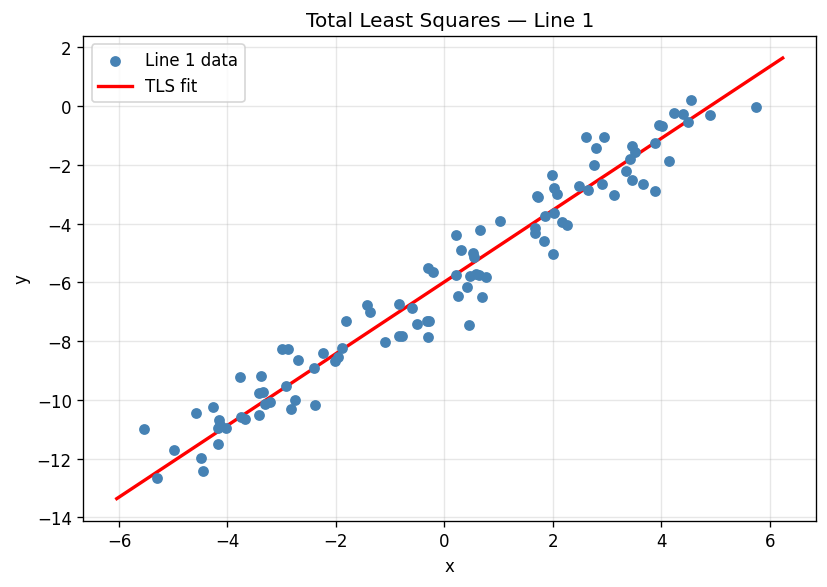

In [4]:
#visualize line 1
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(x1, y1, color='steelblue', label='Line 1 data', zorder=3, s=30)

x_range = np.linspace(x1.min() - 0.5, x1.max() + 0.5, 300)
if abs(b1) > 1e-10:
    y_fit = (-a1 * x_range - c1) / b1
    ax.plot(x_range, y_fit, 'r-', linewidth=2, label='TLS fit')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Total Least Squares — Line 1')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/q1a_line1.png', dpi=150)
plt.show()

#### Q1(b)

In [5]:
#flatten all columns
X_cols = D[:, :3]
Y_cols = D[:, 3:]
X_all = X_cols.flatten()
Y_all = Y_cols.flatten()

print(f'Total points: {len(X_all)}')

Total points: 300


In [6]:
X_cols = D[:, :3]
y_cols = D[:, 3:]

X_all = X_cols.flatten().reshape(-1, 1)
y_all = y_cols.flatten()

remaining_X = X_all.copy()
remaining_y = y_all.copy()

lines = []

for i in range(3):
    ransac = RANSACRegressor(
        LinearRegression(),
        min_samples=20,      
        residual_threshold=1.0,
        max_trials=2000,
        random_state=42
    )
    
    ransac.fit(remaining_X, remaining_y)
    inlier_mask = ransac.inlier_mask_
    
    print(f"Line {i+1}: inliers found = {inlier_mask.sum()}")
    
    coef = ransac.estimator_.coef_[0]
    intercept = ransac.estimator_.intercept_
    lines.append((coef, intercept))
    
    remaining_X = remaining_X[~inlier_mask]
    remaining_y = remaining_y[~inlier_mask]

for i, (m, c) in enumerate(lines):
    print(f"Line {i+1}: y = {m:.4f}x + {c:.4f}")

Line 1: inliers found = 105
Line 2: inliers found = 67
Line 3: inliers found = 73
Line 1: y = -0.4081x + 1.9151
Line 2: y = 1.0313x + 0.8088
Line 3: y = 1.1895x + -5.9631


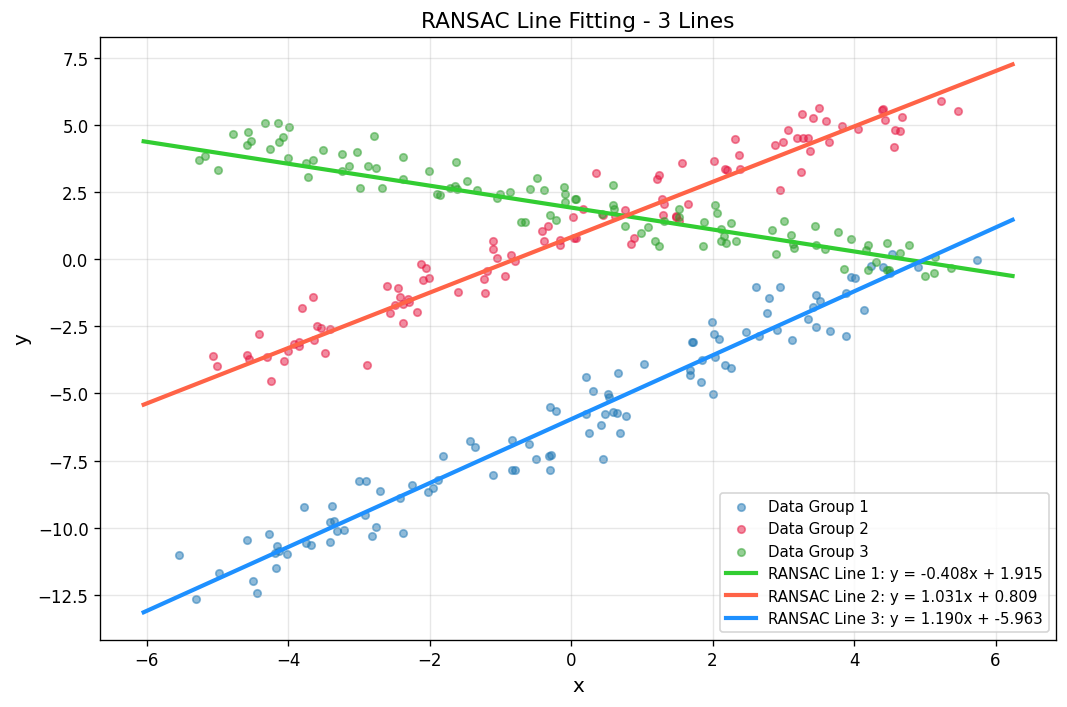

In [7]:
#plotting 3 RANSAC lines
fig, ax = plt.subplots(figsize=(9, 6))

colors       = ['limegreen', 'tomato', 'dodgerblue']
group_colors = ['#1f77b4', "#e61640", '#2ca02c']

#data points
for gi in range(3):
    ax.scatter(X_cols[:, gi], y_cols[:, gi],
               s=20, alpha=0.5, color=group_colors[gi],
               label=f'Data Group {gi+1}')

#RANSAC-fitted lines
x_range = np.linspace(X_all.min() - 0.5, X_all.max() + 0.5, 300)
for i, (m, c) in enumerate(lines):
    y_fit = m * x_range + c
    ax.plot(x_range, y_fit,
            color=colors[i], linewidth=2.5,
            label=f'RANSAC Line {i+1}: y = {m:.3f}x + {c:.3f}')

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title('RANSAC Line Fitting - 3 Lines', fontsize=13)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/q1b_ransac_lines.png', dpi=150)
plt.show()

#### Q2

In [8]:
#camera parameters 
f   = 8.0 
d_i = 720.0  
px  = 2.2e-3 

In [9]:
#object distance using thin lens equation
d_o = (f * d_i) / (d_i - f)
print(f"Object distance d_o = {d_o:.4f} mm")

Object distance d_o = 8.0899 mm


In [10]:
#magnification
M = d_i / d_o
print(f"Magnification M = {M:.6f}")

Magnification M = 89.000000


In [11]:
#scale factor
scale = px / M
print(f"Scale = {scale:.6f} mm/pixel")

Scale = 0.000025 mm/pixel


In [12]:
#measure pixel dimensions from image
outer_diameter_px = 383
inner_diameter_px = 304
wire_thickness_px  = 33 

outer_mm = outer_diameter_px * scale
inner_mm = inner_diameter_px * scale
wire_mm  = wire_thickness_px  * scale

print(f"\nEarring Dimensions:")
print(f"Outer diameter : {outer_diameter_px} px → {outer_mm:.5f} mm")
print(f"Inner diameter : {inner_diameter_px} px → {inner_mm:.5f} mm")
print(f"Wire thickness : {wire_thickness_px} px → {wire_mm:.5f} mm")


Earring Dimensions:
Outer diameter : 383 px → 0.00947 mm
Inner diameter : 304 px → 0.00751 mm
Wire thickness : 33 px → 0.00082 mm


#### Q3

In [16]:
#4 turf points
points = []

def mouse_callback(event, x, y, flags, param):
    global points, img_display
    if event == cv2.EVENT_LBUTTONDOWN:
        if len(points) < 4:
            points.append((x, y))
            print(f"Point {len(points)}: ({x}, {y})")
            cv2.circle(img_display, (x, y), 5, (0, 0, 255), -1)
            cv2.imshow("Image", img_display)
        if len(points) == 4:
            print("\nFour points selected:")
            for i, p in enumerate(points):
                print(f"P{i+1}: {p}")

img = cv2.imread("images/turf.jpg")
if img is None:
    raise FileNotFoundError("Image not found.")

img_display = img.copy()
cv2.namedWindow("Image")
cv2.setMouseCallback("Image", mouse_callback)
cv2.imshow("Image", img_display)
cv2.waitKey(0)
cv2.destroyAllWindows()

points = np.array(points, dtype=np.float32)
print("\nFinal array of selected points:")
print(points)

Point 1: (683, 162)
Point 2: (841, 160)
Point 3: (1332, 669)
Point 4: (106, 663)

Four points selected:
P1: (683, 162)
P2: (841, 160)
P3: (1332, 669)
P4: (106, 663)

Final array of selected points:
[[ 683.  162.]
 [ 841.  160.]
 [1332.  669.]
 [ 106.  663.]]


In [17]:
#flag
flag = cv2.imread("images/flag.jpg")
if flag is None:
    raise FileNotFoundError("Flag image not found.")

In [18]:
h, w = flag.shape[:2]

#4 corners
dst_points = np.array([
    [0,     0    ],
    [w - 1, 0    ],
    [w - 1, h - 1],
    [0,     h - 1]
], dtype=np.float32)

#homography
H, _ = cv2.findHomography(dst_points, points)

print("Homography matrix H:")
print(np.round(H, 4))

Homography matrix H:
[[ 2.401e-01 -5.231e-01  6.830e+02]
 [-4.500e-03 -5.870e-02  1.620e+02]
 [-0.000e+00 -7.000e-04  1.000e+00]]


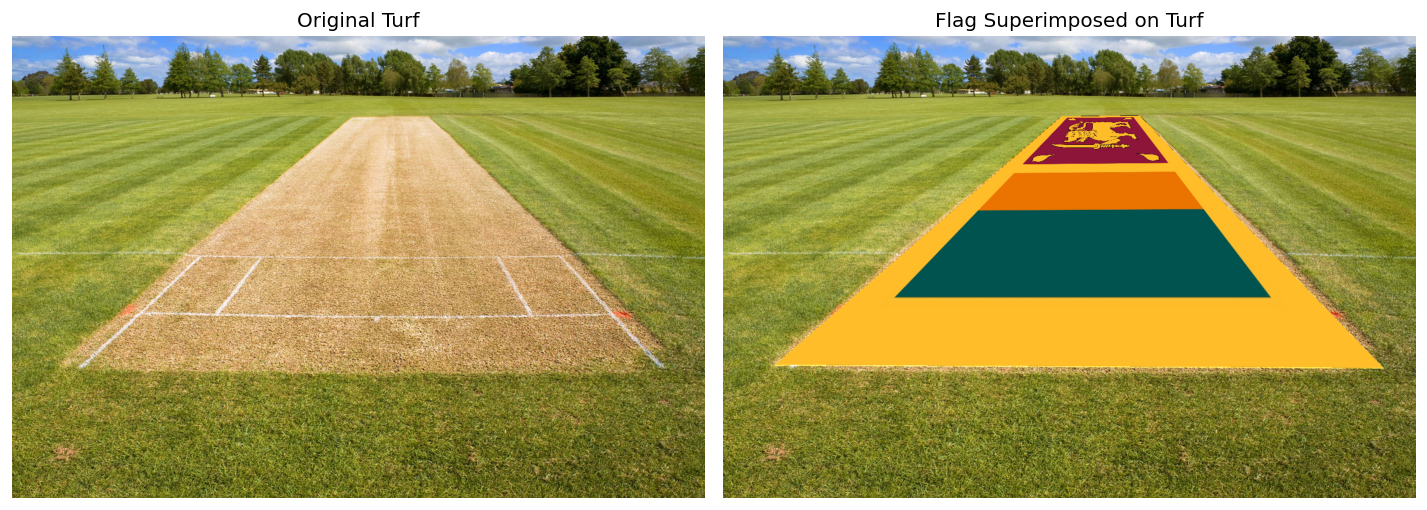

Saved: outputs/q3_flag_on_turf.png


In [19]:
#flag on turf
warped_flag = cv2.warpPerspective(flag, H, (img.shape[1], img.shape[0]))

mask     = np.zeros_like(img, dtype=np.uint8)
cv2.fillConvexPoly(mask, points.astype(int), (255, 255, 255))
mask_inv  = cv2.bitwise_not(mask)
img_bg    = cv2.bitwise_and(img, mask_inv)
final_img = cv2.add(img_bg, warped_flag)

#results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Turf')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))
axes[1].set_title('Flag Superimposed on Turf')
axes[1].axis('off')

plt.tight_layout()
plt.savefig('outputs/q3_flag_on_turf.png', dpi=150)
plt.show()
print("Saved: outputs/q3_flag_on_turf.png")